Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

Checking whether GPU is there

In [25]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Importing all the important libraries

In [45]:
import glob
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files
from tqdm import tqdm
from collections import Counter
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import matplotlib.pyplot as plt
import seaborn as sns # Plotting library


In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


## Dataset and Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [27]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Test')

Total number of images in train and test

In [30]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("image_count_train :",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("image_count_test :",image_count_test)

image_count_train : 2239
image_count_test : 118


No. of classes/folders

In [31]:
folder_count_train = len(list(data_dir_train.glob('*')))
print("folder_count_train :",folder_count_train)
folder_count_test = len(list(data_dir_test.glob('*')))
print("folder_count_test :",folder_count_test)

folder_count_train : 9
folder_count_test : 9


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [34]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [35]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [36]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

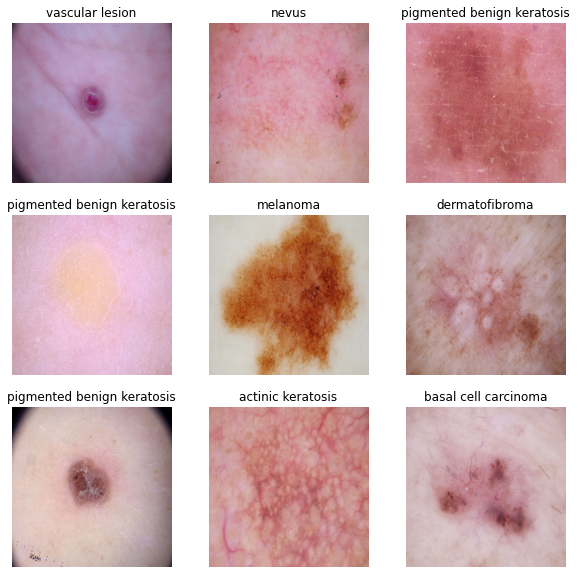

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Found 2239 files belonging to 9 classes.


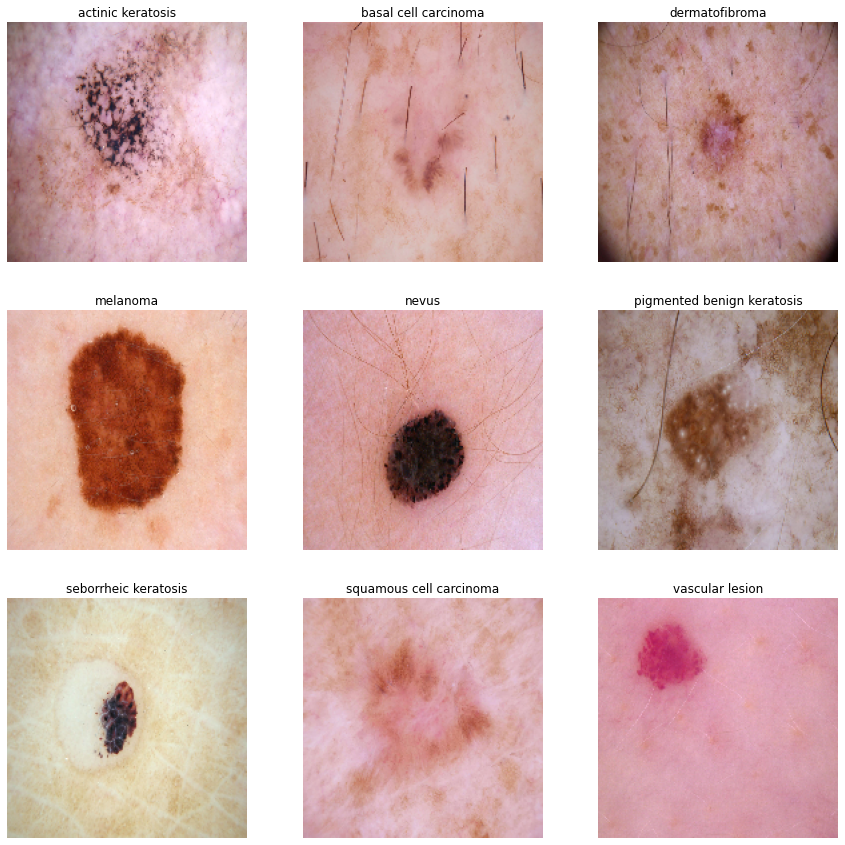

In [38]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


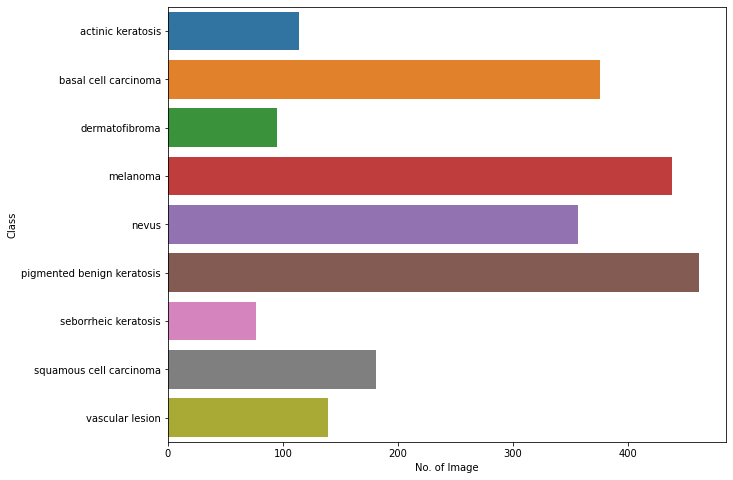

In [40]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

Ans - seborrheic keratosis	

#### - Which classes dominate the data in terms proportionate number of samples?

Ans - actinic keratosis, seborrheic keratosis, vascular lesion and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

The highest number of samples are in pigmented benign keratosis	

#### **Todo:** Rectify the class imbalance


There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
#install Augmentor
# !pip install Augmentor
for i in class_names:
    print(i)

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


In [21]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(source_directory=path_to_training_dataset + i, output_directory="output")
    p.rotate(probability=0.8, max_left_rotation=20, max_right_rotation=20)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E32911D50>: 100%|██████████| 500/500 [00:05<00:00, 85.04 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E30C1DF10>: 100%|██████████| 500/500 [00:06<00:00, 80.93 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E30B22E90>: 100%|██████████| 500/500 [00:05<00:00, 84.90 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=944x1127 at 0x7F9E327E1C10>: 100%|██████████| 500/500 [00:27<00:00, 18.16 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F9E30BB8910>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E327E1450>: 100%|██████████| 500/500 [00:06<00:00, 77.96 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9E32894FD0>: 100%|██████████| 500/500 [00:12<00:00, 41.05 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E30B50990>: 100%|██████████| 500/500 [00:05<00:00, 87.03 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E30CC2950>: 100%|██████████| 500/500 [00:05<00:00, 84.20 Samples/s] 


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [52]:
#Count total number of image originally.
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [48]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [53]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [54]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [55]:
# What does TF data experimental autotune do?
# AUTOTUNE , which will prompt the tf. data runtime to tune the value dynamically at runtime. Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

---

Custom Model-1

In [117]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [ ]:
# ### just a practice model so commented

# input_shape = (180,180,3)
# lr = 1e-5
# init = 'normal'
# activ = 'relu'

# model1 = Sequential()
# model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model1.add(MaxPool2D(pool_size=(2, 2)))

# model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model1.add(BatchNormalization())
# model1.add(MaxPool2D(pool_size=(2, 2)))

# model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model1.add(BatchNormalization())
# model1.add(MaxPool2D(pool_size=(2, 2)))

# model1.add(Flatten())

# model1.add(Dense(512, activation='relu'))
# model1.add(Activation('relu'))
# model1.add(Dropout(0.5))
# model1.add(Dense(1))
# model1.add(Flatten())

# model1.add(Activation('sigmoid'))

# model1.summary()

In [136]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model1 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (180, 180, 32)))
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(num_classes, activation = "softmax"))

---

Custom Model - 2

In [91]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

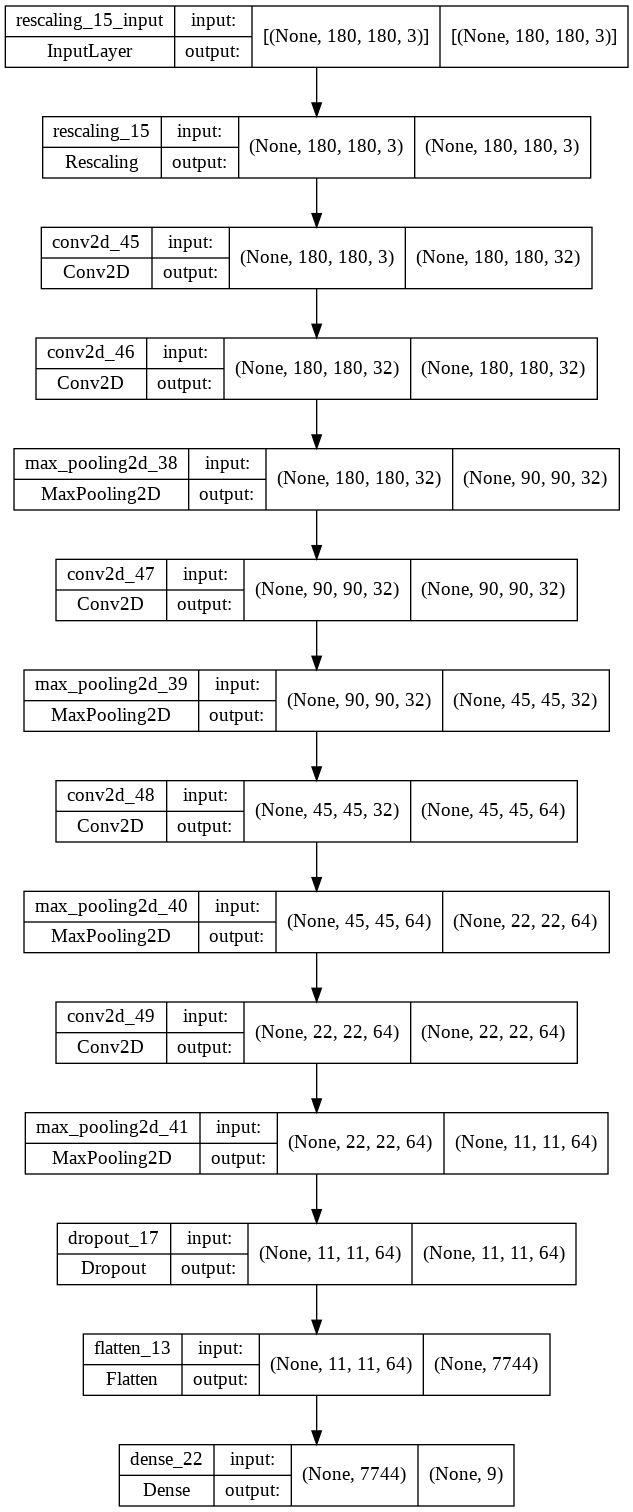

In [137]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model, model_to_dot
# import pydot
# import graphviz
# import pydotplus
from PIL import Image

a = plot_model(model1, to_file='/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/model1_plot.png', show_shapes=True, show_layer_names=True)

im = Image.open("/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/model1_plot.png")
 
im.show()
display(im)

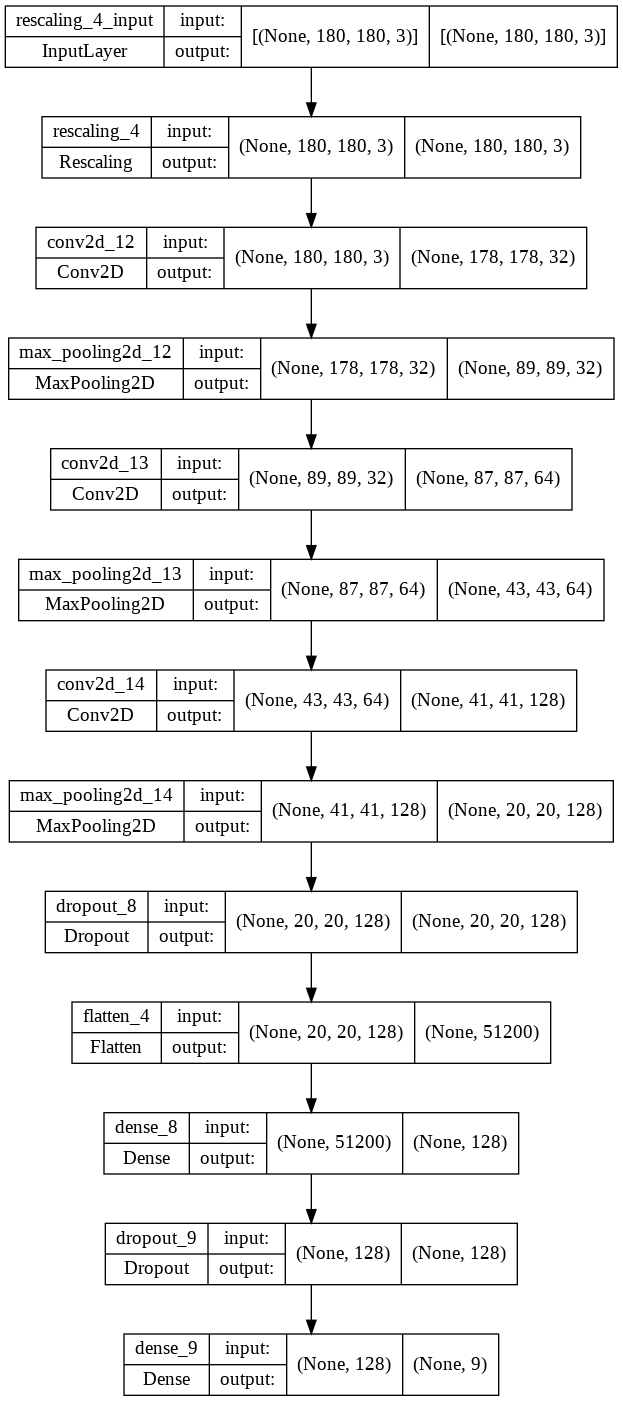

In [92]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model, model_to_dot
# import pydot
# import graphviz
# import pydotplus
from PIL import Image

a = plot_model(model, to_file='/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/model_plot.png', show_shapes=True, show_layer_names=True)

im = Image.open("/content/gdrive/MyDrive/CNN_Skin_Cancer_assignment/model_plot.png")
 
im.show()
display(im)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

---

Compilation for custom model -1 

In [138]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model1.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=8,mode="auto",verbose=1)

In [139]:
# View the summary of all layers
model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_46 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

---

Compilation for Custom Model - 2

In [93]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=8,mode="auto",verbose=1)

---

### Train the model

Training Custom Model 1

In [145]:
epochs = 30
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8646
Epoch 1: val_accuracy improved from -inf to 0.70453, saving model to model1.h5
169/169 [==============================] - 8s 47ms/step - loss: 0.3805 - accuracy: 0.8646 - val_loss: 0.9711 - val_accuracy: 0.7045
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8713
Epoch 2: val_accuracy did not improve from 0.70453
169/169 [==============================] - 8s 47ms/step - loss: 0.3432 - accuracy: 0.8713 - val_loss: 1.0292 - val_accuracy: 0.7016
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8841
Epoch 3: val_accuracy improved from 0.70453 to 0.71715, saving model to model1.h5
169/169 [==============================] - 8s 47ms/step - loss: 0.3127 - accuracy: 0.8841 - val_loss: 1.0042 - val_accuracy: 0.7171
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.8950
Epoch 4:

---


Training Custom Model 2

In [94]:
# Train the model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.9070 - accuracy: 0.2676
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to model.h5
169/169 [==============================] - 5s 25ms/step - loss: 1.9070 - accuracy: 0.2676 - val_loss: 1.6872 - val_accuracy: 0.3333
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.5638 - accuracy: 0.3971
Epoch 2: val_accuracy improved from 0.33333 to 0.44543, saving model to model.h5
169/169 [==============================] - 4s 24ms/step - loss: 1.5638 - accuracy: 0.3971 - val_loss: 1.4853 - val_accuracy: 0.4454
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4927 - accuracy: 0.4253
Epoch 3: val_accuracy improved from 0.44543 to 0.49592, saving model to model.h5
169/169 [==============================] - 4s 24ms/step - loss: 1.4927 - accuracy: 0.4253 - val_loss: 1.3364 - val_accuracy: 0.4959
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.3555

### Visualizing training results

Visualization of training curves for model - 2

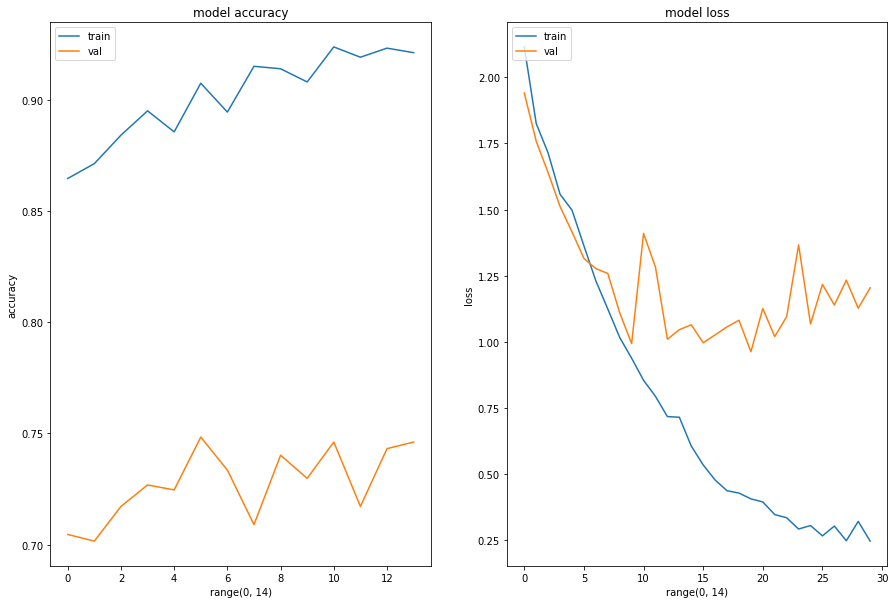

In [147]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

To prevent overfit we have used early stopping



---



Visualization of training curves for model - 2

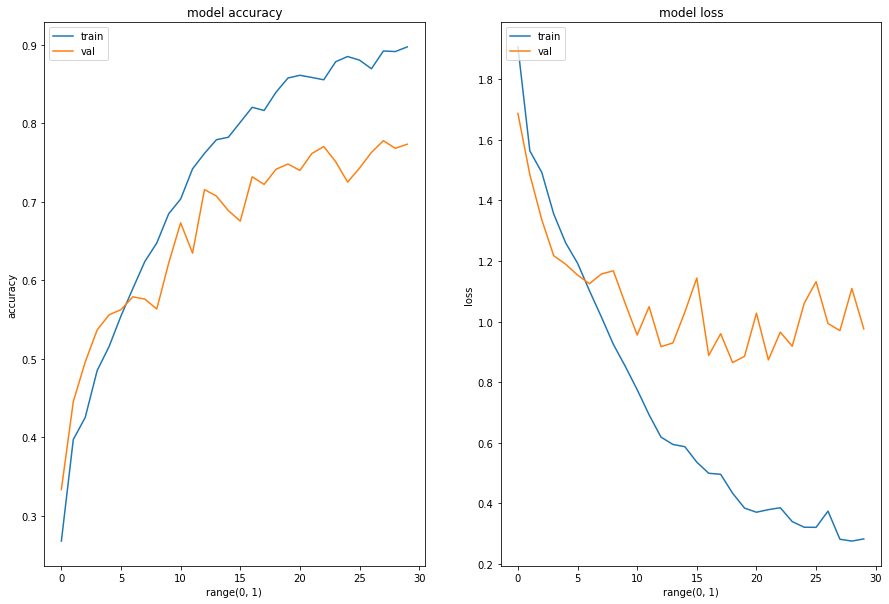

In [95]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

To prevent overfit we have used early stopping

## Model Prediction

In [96]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

##### Model -1 prediction

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


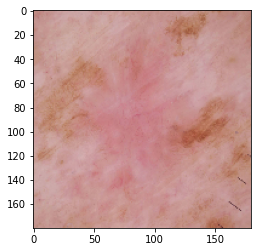

In [148]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )




---



##### Model -2 prediction

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


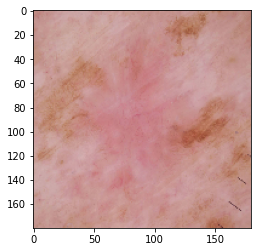

In [97]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )


Finding on the first base model
* The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch
* The accuracy is just around 75-80% because there are enough features to remember the pattern.
* But again, it's too early to comment on the overfitting & underfitting debate

Finding from Custom Model

* There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation
* We can increase the epochs to increase the accuracy so it's too early for judgement

### Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Accuracy on training data has increased by using Augmentor library
- Model is a bit overfitting
- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
- The Model can be further improved by tuning the hyperparameter